In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/free-spoken-digit-dataset-master/recordings'
OUTPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project'

# list all the files and directories within a specified directory
parent_list = os.listdir(INPUT_DIR)
print(len(parent_list)) # 6 speakers, 10 digits, 50 recordings for each digit
for i in range(10):
    print(parent_list[i])

3000
5_nicolas_9.wav
3_yweweler_14.wav
1_lucas_5.wav
2_george_44.wav
4_yweweler_38.wav
3_yweweler_28.wav
4_yweweler_10.wav
3_george_1.wav
1_nicolas_15.wav
1_jackson_42.wav


(2699,)
(2446,)
(2696,)
(2556,)
(3065,)


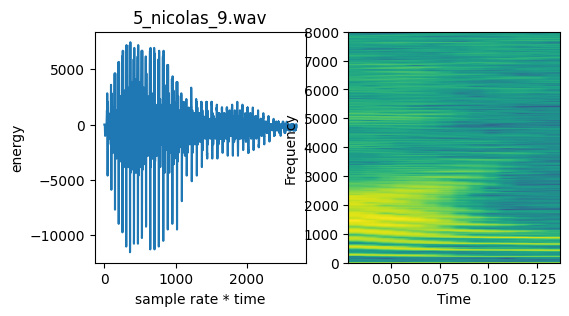

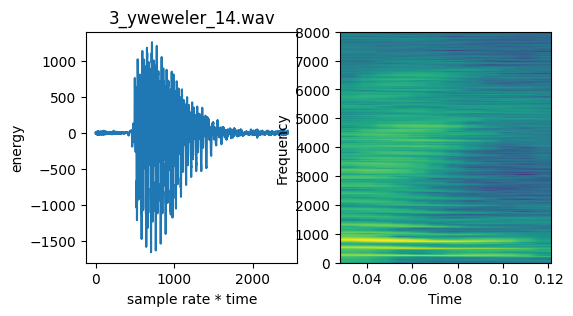

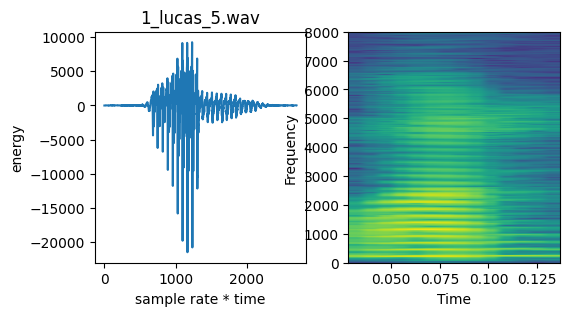

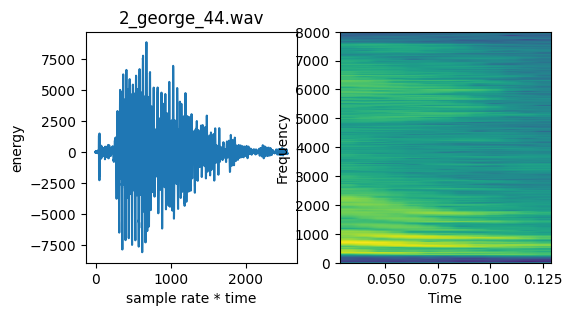

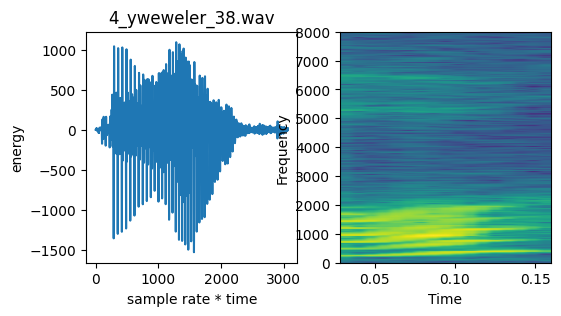

In [3]:
for i in range(5): 
    # wave.open open a .wav file
    signal_wave  = wave.open(os.path.join(INPUT_DIR, parent_list[i]), 'r') 
    # sample rate: the number of audio sampls taken per second
    # setting a low num_frames can result in shorter audio clip
    # set to a higher value will result in read all that are available and remains fill with zero or silence
    # to get frames, here single_wave.fetnframes()
    sample_rate = 16000
    # print(signal_wave.readframes(sample_rate))
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)
    print(sig.shape)
    plt.figure(figsize=(6,3))
    plot_a = plt.subplot(121)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(122)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

In [4]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    for filename in os.listdir(INPUT_DIR):
        if "wav" in filename:
            file_path = os.path.join(INPUT_DIR, filename)
            file_stem = Path(file_path).stem
            target_dir = f'class_{file_stem[0]}'
            dist_dir = os.path.join(OUTPUT_DIR, 'audio-images', target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(dist_dir):
                os.makedirs(dist_dir)
            if not os.path.exists(file_dist_path + '.png'):
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                pylab.specgram(sound_info, Fs = frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_4
class_3
class_2
class_5
class_9
class_0
class_7
class_6
class_1
class_8

A few example files: 

1_yweweler_41.png
1_theo_49.png
1_george_20.png
1_george_34.png
1_jackson_37.png
1_jackson_23.png
1_lucas_36.png
1_nicolas_48.png
1_lucas_22.png
1_nicolas_49.png


In [5]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    directory = os.path.join(OUTPUT_DIR, 'audio-images'),
    shuffle = True,
    color_mode = 'rgb',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "training",
    seed = 0
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    directory = os.path.join(OUTPUT_DIR, 'audio-images'),
    shuffle = True,
    color_mode = 'rgb',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "validation",
    seed = 0
)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Found 3000 files belonging to 10 classes.
Using 600 files for validation.


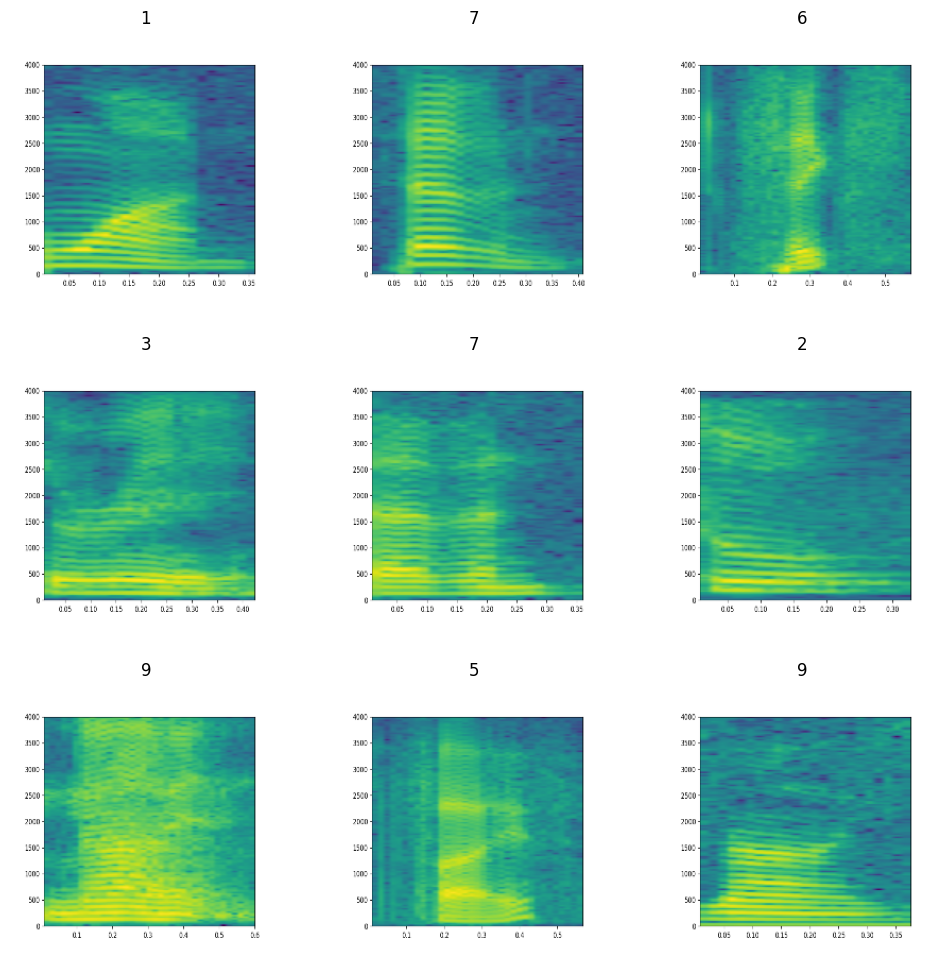

In [6]:
plt.figure(figsize=(12,12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [7]:
def prepare(ds, augment=False):
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential(
        [tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds
train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
75/75 [==============================] - 15s 192ms/step - loss: 0.7133 - accuracy: 0.7812 - val_loss: 5.3740 - val_accuracy: 0.1133
Epoch 2/10
67/75 [=========================>....] - ETA: 1s - loss: 0.2165 - accuracy: 0.9361

KeyboardInterrupt: 

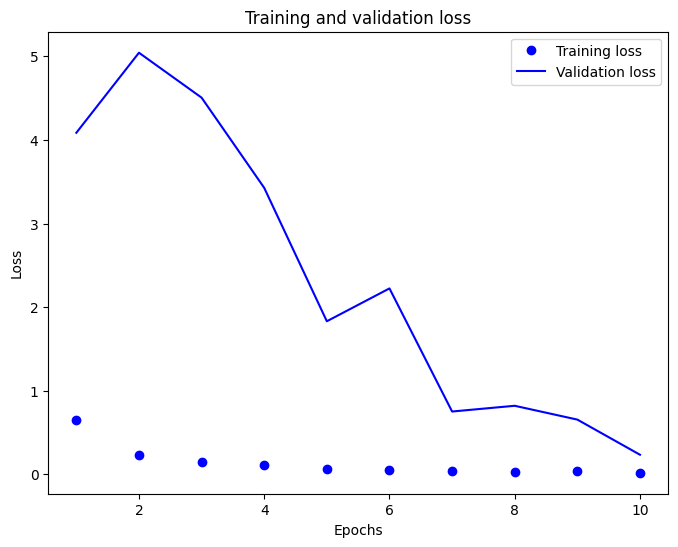

In [9]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

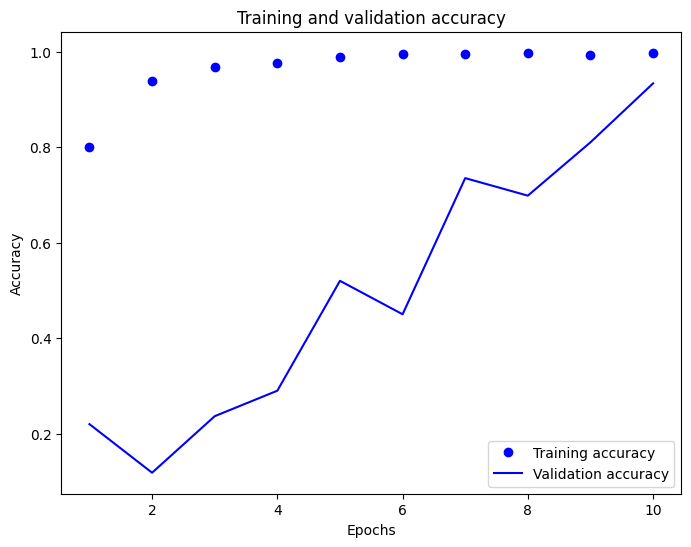

In [10]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.234244, final accuracy: 0.933333


In [12]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                      